# The Distribution of Wealth and the MPC


This notebook presents a selection of results from the paper [The Distribution of Wealth and the Marginal Propensity to Consume](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC), using the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit.  It sketches the steps that would need to be taken to solve the model using the [dolARK](https://github.com/EconForge/dolARK) modeling system.

In [1]:
# This cell does some standard python setup

# Tools for navigating the filesystem
import sys
import os

# Import related generic python packages
import numpy as np
from time import clock
mystr = lambda number : "{:.4f}".format(number)
from copy import copy, deepcopy

# Plotting tools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show

# iPython gives us some interactive and graphical tools
from IPython import get_ipython # In case it was run from python instead of ipython

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

## Abstract

In a model calibrated to match micro- and macroeconomic evidence on household income dynamics, this paper shows that a modest degree of heterogeneity in household preferences or beliefs is sufficient to match empirical measures of wealth inequality in the U.S. The hegerogeneity-augmented model's predictions are consistent with microeconomic evidence that suggests that the annual marginal propensity to consume (MPC) is much larger than the roughly 0.04 implied by commonly-used macroeconomic models (even ones including some heterogeneity).  The high MPC arises because many consumers hold little wealth despite having a strong precautionary motive.  The model also plausibly predicts that the aggregate MPC can differ greatly depending on how the shock is distributed across households (depending, e.g., on their wealth, or employment status).

## Notation For the Core Model

We define the following notation.

| Exogenous Random Variable | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\tshk}{\zeta}\tshk$ | Transitory Income | $\texttt{tshk}$ |  |
| $\newcommand{\pshk}{\psi}\pshk$ | Permanent Shock | $\texttt{pshk}$ |  |

| Parameter | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\PLives}{\Lambda} \PLives$ | Probability of living | $\texttt{PLives}$ | 0.99375
| $\newcommand{\Discount}{\beta}\Discount$ | Time Preference Factor | $\texttt{Discount}$ | 0.96 |
| $\newcommand{\CRRA}{\rho}\CRRA$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 1 |
| $\sigma_\tshk$ | Transitory Income Standard Deviation | $\texttt{PermShkStd}$ | 0.1  |
| $\sigma_\pshk$ | Permanent Shock Standard Deviation |$\texttt{TranShkStd}$ | 0.1 |


| Variable | Description | Code | 
| :---: | ---         | ---  | 
| $\newcommand{\aRat}{a}\aRat$ | Assets | $\texttt{aRat}$ |  
| $\newcommand{\mRat}{m}\mRat$ | Market resources | $\texttt{mRt}$ |  
| $\newcommand{\KLev}{K}\KLev$ | Capital Aggregate | $\texttt{KLev}$
| $\newcommand{\kapShare}{\alpha}\kapShare$ | Capital share | $\texttt{kapShare}$
| $\newcommand{\LLev}{L}\LLev$ | Labor Aggregate | $\texttt{LLev}$
| $\newcommand{\labor}{\ell}\labor$ | Labor share | $\texttt{labor}$ 
| $\newcommand{\kRat}{k}\kRat$ | $K/P$| $\texttt{kRat}$ |  
| $\newcommand{\pRat}{p}\pRat$ | Permanent Income | |  
| $\mathbf{P}$ | | | 
| $\newcommand{\rProd}{r}\rProd$ | Interest rate | $\texttt{rProd}$ |  
| $\newcommand{\yLev}{y} \yLev$ | Income | $\texttt{yLev}$ 
| $\newcommand{\Wage}{W}\Wage$ | Aggregate Wage Rate | $\texttt{Wage}$ | 

| Functions | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\cFunc}{\mathrm{c}}\cFunc$ | Consumption | $\texttt{cFunc}$ |  |
| $\newcommand{\valfn}{\mathrm{v}} \valfn$ | Value | $\texttt{valfn}$
| $\newcommand{\uFunc}{{\mathrm{u}}}\uFunc$ | Utility | $\texttt{uFunc}$ |  |

$\newcommand{\cRat}{c}$
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\PDies}{\mathsf{P}}$
$\newcommand{\ptyLev}{a}$
$\newcommand{\YLev}{Y}$
$\newcommand{\wEndRat}{\aRat}$

The consumer has a standard Constant Relative Risk Aversion utility function $$u(c)=\frac{c^{1-\rho}}{1-\rho}$$

The idiosyncratic (household) income process is logarithmic Friedman:
\begin{eqnarray*}
\yLev_{t+1}&=&\pRat_{t+1}\tshk_{t+1}\Wage\\
\pRat_{t+1}&=&\pRat_{t}\pshk_{t+1}
\end{eqnarray*}

The Bellman form of the value function for households is:

\begin{eqnarray*}
\valfn(\mRat_{t})&=&\underset{\cFunc_{t}}{\max } ~~ \uFunc(\cFunc_{t}(\mRat_t))+\Discount \PLives \Ex_{t}\left[ \pshk_{t+1}^{1-\CRRA}\valfn(\mRat_{t+1})
\right]   \\
\notag &\text{s.t.}&\\
\wEndRat_{t} &=&\mRat_{t}-\cRat_{t},\\
\wEndRat_{t} &\geq &0, \\
\kRat_{t+1} &=&\wEndRat_{t}/(\PLives \pshk_{t+1}),
\\
\mRat_{t+1} &=&(\daleth +\rProd_t)\kRat_{t+1}+\tshk_{t+1},\\
\rProd &=&\kapShare\ptyLev(\KLev/\labor\LLev)^{\kapShare-1}\\
\end{eqnarray*}

In [2]:
'''
This will run the absolute minimum amount of work that actually produces
relevant output-- no aggregate shocks, perpetual youth, matching net worth.
Will run both beta-point and beta-dist versions.
'''
import os

'''
Copied here from do_min.py.
Design decisions about whether to include this code explicitly,
or import it, or execute it as is here, TBD.
'''

here = os.path.dirname(os.path.realpath("cstwMPC.ipynb"))
my_path = os.path.join(here,'')
path_to_models = os.path.join(my_path,'Code')

In [3]:
# For speed here, use the "tractable" version of the model
# This is not the "right" model, but illustrates the key point
'''
This options file specifies parameter heterogeneity, making the choice in the paper:
uniformly distributed discount factors.
'''
param_name = 'DiscFac'        # Which parameter to introduce heterogeneity in
dist_type = 'uniform'         # Which type of distribution to use

'''
This options file specifies the "standard" work options for cstwMPC, estimating the model only.
'''
run_estimation = True         # Runs the estimation if True
run_sensitivity = [False, False, False, False, False, False, False, False] # Choose which sensitivity analyses to run: rho, xi_sigma, psi_sigma, mu, urate, mortality, g, R
find_beta_vs_KY = False       # Computes K/Y ratio for a wide range of beta; should have do_beta_dist = False
do_tractable = True          # Uses a "tractable consumer" rather than solving full model when True

Beginning an estimation with the specification name PYbetaPointIndNetWorth...





getKYratioDifference tried center = 0.95 and got -9.737467406398238
The given type violates the Absolute Impatience Condition with the supplied parameter values; the AIF is 1.00495  
The given parameter values violate the Growth Impatience Condition for this consumer type; the GIF is: 1.0050 


The given parameter values violate the Growth Impatience Condition for this consumer type; the GIF is: 1.0050 
getKYratioDifference tried center = 0.995 and got 65.56174461486972





getKYratioDifference tried center = 0.9558192645251606 and got -9.682962081909512





getKYratioDifference tried center = 0.9754096322625803 and got -9.30238283304393





getKYratioDifference tried center = 0.9852048161312901 and got -8.202435342294791
The given type violates the Absolute Impatience Condition with the supplied parameter values; the AIF is 1.00000  
The given parameter values violate the Growth Impatience Condition 

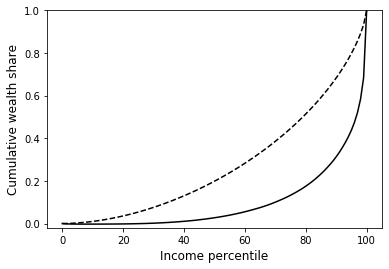

Estimate is center=0.9891395234236353, spread=0.0
Lorenz distance is 42.691225404510476
Average MPC for all consumers is 0.099
Average MPC in the top percentile of W/Y is 0.068
Average MPC in the top decile of W/Y is 0.071
Average MPC in the top quintile of W/Y is 0.072
Average MPC in the second quintile of W/Y is 0.074
Average MPC in the middle quintile of W/Y is 0.074
Average MPC in the fourth quintile of W/Y is 0.076
Average MPC in the bottom quintile of W/Y is 0.199
Average MPC in the top percentile of y is 0.075
Average MPC in the top decile of y is 0.078
Average MPC in the top quintile of y is 0.084
Average MPC in the second quintile of y is 0.114
Average MPC in the middle quintile of y is 0.123
Average MPC in the fourth quintile of y is 0.082
Average MPC in the bottom quintile of y is 0.093
Average MPC for the employed is 0.097
Average MPC for the unemployed is 0.131
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
61.057% are in the bottom wealt

In [4]:
# Solve for the $\beta-Point$ (do_param_dist=False) for speed
'''
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
'''
do_param_dist = False          # Do param-dist version if True, param-point if False
do_lifecycle = False          # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False         # Solve the FBS aggregate shocks version of the model
do_liquid = False            # Matches liquid assets data when True, net worth data when False


os.chdir(path_to_models)
exec(open('cstwMPC_MAIN.py').read())

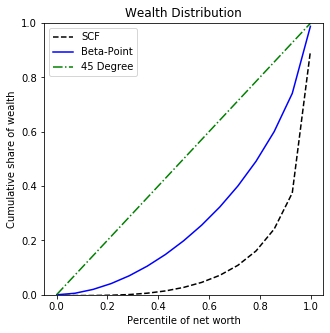

In [5]:
# Get some tools for plotting simulated vs actual wealth distributions
from HARK.utilities import getLorenzShares, getPercentiles

# The cstwMPC model conveniently has data on the wealth distribution 
# from the U.S. Survey of Consumer Finances
from HARK.cstwMPC.SetupParamsCSTW import SCF_wealth, SCF_weights

# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001,0.999,15)
SCF_Lorenz_points = getLorenzShares(SCF_wealth,weights=SCF_weights,percentiles=pctiles)

sim_wealth = EstimationEconomy.aLvlNow[0]
sim_Lorenz_points = getLorenzShares(sim_wealth,percentiles=pctiles)

# Plot 
plt.figure(figsize=(5,5))
plt.title('Wealth Distribution')
plt.plot(pctiles,SCF_Lorenz_points,'--k',label='SCF')
plt.plot(pctiles,sim_Lorenz_points,'-b',label='Beta-Point')
plt.plot(pctiles,pctiles,'g-.',label='45 Degree')
plt.xlabel('Percentile of net worth')
plt.ylabel('Cumulative share of wealth')
plt.legend(loc=2)
plt.ylim([0,1])
plt.show('wealth_distribution_1')

## Time Preference Heterogeneneity

Our specific approach is to replace the assumption that all households have the same time
preference factor with an assumption that, for some dispersion $\nabla$, time
preference factors are distributed uniformly in the population between
$\grave{\Discount}-\nabla$ and $\grave{\Discount}+\nabla$ (for this reason, the model is referred to as the $\Discount$-Dist model).  Then,
using simulations, we search for the values of $\grave{\Discount}$ and
$\nabla$ for which the model best matches the fraction of net worth held by the top $20$, $40$, $60$, and $80$ percent of the population, while at the same time matching
the aggregate capital-to-output ratio from the perfect foresight
model. Specifically, defining $w_{i}$ and $\omega _{i}$ as the proportion of total aggregate net worth held by the top $i$ percent in our model and in the data, respectively, we solve the following minimization problem:

$$  \{\grave{\Discount}, \nabla\}= \underset{\{{\Discount}, \nabla\}}{\text{argmin} }\Big(\sum_\text{i=20, 40, 60, 80}
  \big(w_{i}({\Discount}, \nabla)-\omega _{i}\big)^{2}\Big)^{1/2}$$
  subject to the constraint that the aggregate wealth (net worth)-to-output ratio in the model matches the aggregate
capital-to-output ratio from the perfect foresight model ($\KLev_{PF}/\YLev_{PF}$). When solving the problem for the FBS specification we shut down the aggregate shocks (practically, this does not affect the estimates given their small size).
 
$$\KLev / \YLev = \KLev_{PF} / \YLev_{PF}$$

The solution to this problem is $\{\grave{\Discount}, \nabla\}=\{0.9867, 0.0067\}$
, so that the discount factors are evenly spread roughly between 0.98 and 0.99. We call the optimal value of the objective function the 'Lorenz distance' and use it as a measure of fit of the models.

The introduction of even such a relatively modest amount of time
preference heterogeneity sharply improves the model's fit to the targeted
proportions of wealth holdings, bringing it reasonably in line with the data.

In [ ]:
'''
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
'''
do_param_dist = True          # Do param-dist version if True, param-point if False
do_lifecycle = False          # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False         # Solve the FBS aggregate shocks version of the model
do_liquid = True              # Matches liquid assets data when True, net worth data when False
do_tractable = True           # 
os.chdir(path_to_models)
exec(open('cstwMPC_MAIN.py').read())

Beginning an estimation with the specification name PYbetaDistIndLiquid...
getKYratioDifference tried center = 0.95 and got -6.075744713972091
getKYratioDifference tried center = 0.995 and got 111.76737279427269
getKYratioDifference tried center = 0.9523201058993506 and got -6.055195625199659
getKYratioDifference tried center = 0.9736600529496753 and got -5.684198676919181
getKYratioDifference tried center = 0.9843300264748376 and got -3.0115687152149486
getKYratioDifference tried center = 0.9896650132374187 and got 16.765594594165385
getKYratioDifference tried center = 0.9851424119003377 and got -1.7495265290069613
getKYratioDifference tried center = 0.9861621794459002 and got 0.464734381802705
getKYratioDifference tried center = 0.985948148191699 and got -0.06632048718483752
getKYratioDifference tried center = 0.9859748773639189 and got -0.00206330128011345
getKYratioDifference tried center = 0.9859757318452261 and got -6.473122304839762e-07
getKYratioDifference tried center = 0.9859

In [ ]:
# Plot 
plt.figure(figsize=(5,5))
plt.title('Wealth Distribution')
plt.plot(pctiles,SCF_Lorenz_points,'--k',label='SCF')
plt.plot(pctiles,sim_Lorenz_points,'-b',label='Beta-Dist')
plt.plot(pctiles,pctiles,'g-.',label='45 Degree')
plt.xlabel('Percentile of net worth')
plt.ylabel('Cumulative share of wealth')
plt.legend(loc=2)
plt.ylim([0,1])
plt.show('wealth_distribution_2')